In [60]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torchvision import datasets, transforms

# Data preparation


1.   get path
2.   dataloader for img and mask
1.   split into test and validation





In [2]:
#define dataset for img and mask
file_dir = "/content/drive/MyDrive/ColabGitHub/ISIC2018_Task1-2_Training_Data"
os.chdir(file_dir)

img_path = './ISIC2018_Task1-2_Training_Input_x2'
mask_path = './ISIC2018_Task1_Training_GroundTruth_x2'

imgs = [file for file in sorted(os.listdir(img_path)) if file.endswith('.jpg')]
masks = [file for file in sorted(os.listdir(mask_path)) if file.endswith('.png')]

In [3]:
from torchvision import datasets
from torchvision.datasets import  ImageFolder
from torch.utils.data import dataloader, random_split, Subset
from torchvision.transforms import transforms


In [4]:
from torch.utils.data import Dataset
from PIL import Image

class Unet_dataset(Dataset):
  def __init__(self,
               img_dir = './ISIC2018_Task1-2_Training_Input_x2',
               mask_dir = './ISIC2018_Task1_Training_GroundTruth_x2', 
               img_transforms=None,
               mask_transforms= None,
               train_ratio = 0.5):
    
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

    self.imgs = [file for file in sorted(os.listdir(self.img_dir)) if file.endswith('.jpg')]
    self.masks = [file for file in sorted(os.listdir(self.mask_dir)) if file.endswith('.png')]

    self.train_ratio = train_ratio

  #meke dataloader
  def load_data(self, idx):
    img_path = os.path.join(self.img_dir, self.imgs[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    return img, mask

  def __getitem__(self, idx):
    img, mask = self.load_data(idx)
    #transformation
    if self.img_transforms is not None:
      img = self.img_transforms(img)
    if self.mask_transforms is not None:
      mask = self.mask_transforms(mask)
    return img, mask

  def __len__(self):
    return len(self.imgs)

In [5]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

img_tfs = transforms.Compose([
                                 transforms.Resize((64,64)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
                                 ]
                                )

mask_tfs = transforms.Compose([
                                 transforms.Resize((64,64)),
                                 transforms.ToTensor(),
                                 ]
                                )

dataset = Unet_dataset(img_transforms=img_tfs, mask_transforms=mask_tfs)

#shuffle index
sample_size = len(imgs)
train_size = int(sample_size*0.8)
test_size = sample_size - train_size

#train and test set
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(123))

#dataloader
train_loader= DataLoader(train_set, batch_size=64, shuffle = True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

# Unet

In [8]:
import torch
import torch.nn as nn

In [9]:
class twotimes_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(twotimes_conv, self).__init__()
    self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride = 1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )

  def forward(self, x):
    return self.conv(x)


class Unet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, feature_size=None):
    super(Unet, self).__init__()
    self.downsample = nn.ModuleList()
    self.upsample = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.feature_size = None

    #Downsample frame
    for feature in feature_size:
      self.downsample.append(twotimes_conv(in_channels, feature))
      in_channels = feature

    #Upsample frame
    for feature in reversed(feature_size):
      #Deconvolution
      self.upsample.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride =2))
      #Convolution
      self.upsample.append(twotimes_conv(feature*2, feature))

    #Bottleneck frame
    self.bottleneck = twotimes_conv(feature_size[-1], feature_size[-1]*2)
    self.final_conv = nn.Conv2d(feature_size[0], out_channels, kernel_size=1)


  def forward(self, x):
    skip_connections = []

    #Downsampling steps
    for down_i in self.downsample:
      x = down_i(x)
      #preserve location
      skip_connections.append(x)
      x = self.pool(x)

    #Bottle neck part
    x = self.bottleneck(x)
    skip_connections = skip_connections[: : -1]

    #Upsampling steps
    for idx in range(0, len(self.upsample), 2):
      x = self.upsample[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = torchvision.transforms.resize(x, size=skip_connection.shape[2:])
      
      #where + what
      concatnate_skip = torch.cat((skip_connection, x), dim=1)
      x = self.upsample[idx+1](concatnate_skip)
      
    x = self.final_conv(x)
    output = F.sigmoid(x)
    
    return output

In [52]:
#dice coef
def dice_coef(pred, target):
  batch_size = len(pred)
  somooth = 1.

  pred_flat = pred.view(batch_size, -1)
  target_flat = target.view(batch_size, -1)

  intersection = (pred_flat*target_flat).sum()
  dice_coef = (2.*intersection+somooth)/(pred_flat.sum()+target_flat.sum()+somooth)
  return dice_coef


#loss
def dice_loss(pred, target):
  dice_loss = 1 - dice_coef(pred, target)
  return dice_loss

In [12]:
import torch.optim as optim

#set parameters
feature_size=[64, 128, 256, 512]
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 30

model = Unet(feature_size=feature_size)

In [ ]:
from tqdm import tqdm

TRAIN_LOSS = []
TRAIN_DICE = []
TEST_LOSS =[]
TEST_DICE = []

for epoch in range(1, EPOCHS+1):
  print('EPOCH {}/{}'.format(epoch, EPOCHS))
  running_loss = 0
  running_dicecoef = 0
  running_loss_test = 0
  running_dicecoef_test = 0
  BATCH_NUM = len(train_loader)
  BATCH_NUM_TEST = len(test_loader)

  #training
  with tqdm(train_loader, unit='batch') as tbatch:
    for batch_idx, (x, y) in enumerate(tbatch):
      tbatch.set_description(f'Batch: {batch_idx}')

      optimizer.zero_grad()
      output = model(x)
      loss = dice_loss(output, y)
      dicecoef = dice_coef(output, y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_dicecoef += dicecoef.item()

      tbatch.set_postfix(loss=loss.item(), dice_coef=dicecoef.item())

  epoch_loss = running_loss/BATCH_NUM
  epoch_dicecoef = running_dicecoef/BATCH_NUM
  TRAIN_LOSS.append(epoch_loss)
  TRAIN_DICE.append(epoch_dicecoef)

  #test
  with tqdm(test_loader, unit='batch') as tsbatch:
    for batch_idx, (x, y) in enumerate(tsbatch):
      tsbatch.set_description(f'Batch: {batch_idx}')
      output_test = model(x)
      loss_test = dice_loss(output_test, y)
      dicecoef_test = dice_coef(output_test, y)
      tsbatch.set_postfix(loss=loss_test.item(), dice_coef=dicecoef_test.item())

      running_loss_test += loss_test.item()
      running_dicecoef_test += dicecoef_test.item()

  TEST_LOSS.append(running_loss_test/BATCH_NUM_TEST)
  TEST_DICE.append(running_dicecoef_test/BATCH_NUM_TEST)

EPOCH 1/30


Batch: 0:   0%|          | 0/33 [00:04<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.17s/batch, dice_coef=0.684, loss=0.316]


EPOCH 2/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.21s/batch, dice_coef=0.766, loss=0.234]


EPOCH 3/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.07s/batch, dice_coef=0.785, loss=0.215]


EPOCH 4/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.09s/batch, dice_coef=0.815, loss=0.185]


EPOCH 5/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.17s/batch, dice_coef=0.882, loss=0.118]


EPOCH 6/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.15s/batch, dice_coef=0.842, loss=0.158]


EPOCH 7/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.15s/batch, dice_coef=0.823, loss=0.177]


EPOCH 8/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.11s/batch, dice_coef=0.852, loss=0.148]


EPOCH 9/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.08s/batch, dice_coef=0.872, loss=0.128]


EPOCH 10/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.11s/batch, dice_coef=0.851, loss=0.149]


EPOCH 11/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.08s/batch, dice_coef=0.836, loss=0.164]


EPOCH 12/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.10s/batch, dice_coef=0.875, loss=0.125]


EPOCH 13/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.10s/batch, dice_coef=0.832, loss=0.168]


EPOCH 14/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.15s/batch, dice_coef=0.875, loss=0.125]


EPOCH 15/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.16s/batch, dice_coef=0.847, loss=0.153]


EPOCH 16/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.07s/batch, dice_coef=0.859, loss=0.141]


EPOCH 17/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.11s/batch, dice_coef=0.863, loss=0.137]


EPOCH 18/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.22s/batch, dice_coef=0.893, loss=0.107]


EPOCH 19/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.16s/batch, dice_coef=0.887, loss=0.113]


EPOCH 20/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.08s/batch, dice_coef=0.894, loss=0.106]


EPOCH 21/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.10s/batch, dice_coef=0.87, loss=0.13]


EPOCH 22/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.08s/batch, dice_coef=0.896, loss=0.104]


EPOCH 23/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.09s/batch, dice_coef=0.878, loss=0.122]


EPOCH 24/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.10s/batch, dice_coef=0.906, loss=0.0941]


EPOCH 25/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.11s/batch, dice_coef=0.898, loss=0.102]


EPOCH 26/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.08s/batch, dice_coef=0.869, loss=0.131]


EPOCH 27/30


Batch: 8: 100%|██████████| 9/9 [01:21<00:00,  9.09s/batch, dice_coef=0.913, loss=0.0868]


EPOCH 28/30


Batch: 8: 100%|██████████| 9/9 [01:23<00:00,  9.24s/batch, dice_coef=0.888, loss=0.112]


EPOCH 29/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.22s/batch, dice_coef=0.902, loss=0.0982]


EPOCH 30/30


Batch: 8: 100%|██████████| 9/9 [01:22<00:00,  9.13s/batch, dice_coef=0.879, loss=0.121]


In [ ]:
#save model
filename = "Unet_ISIC1.pth"
torch.save(model.state_dict(), filename)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


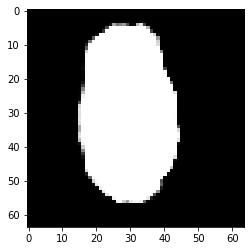

In [ ]:
model.eval()
p = model(x)[0]
plt.imshow(p.detach().squeeze(), cmap='gray')

# Model Evaluation

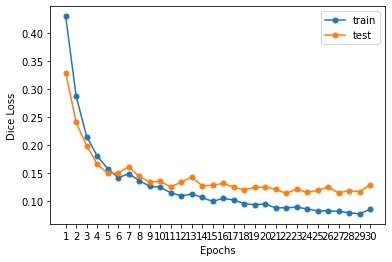

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(1,EPOCHS+1)

plt.plot(X, TRAIN_LOSS, marker='.', markersize=10, label='train')
plt.plot(X, TEST_LOSS, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.xticks(X)
plt.legend()
plt.show()

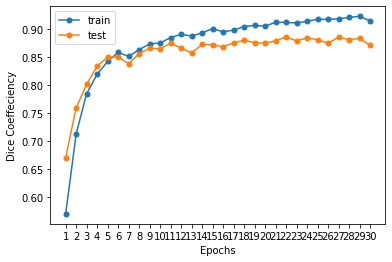

In [ ]:
plt.plot(X, TRAIN_DICE, marker='.', markersize=10, label='train')
plt.plot(X, TEST_DICE, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Coeffeciency')
plt.xticks(X)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


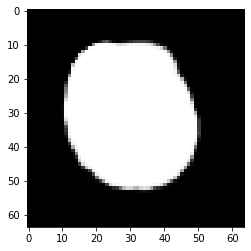

In [13]:
#load model
new_model = Unet(feature_size=feature_size)

filename = "Unet_ISIC1.pth"
checkpoint = torch.load(filename)

new_model.load_state_dict(checkpoint)

p = new_model(x)[0]
plt.imshow(p.detach().squeeze(), cmap='gray')